<a href="https://colab.research.google.com/github/adityapatilisop/Amazon-sagemaker-project/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Facial Emotion Recognition - XCeption Model</center></h1>
<center> A project for the French Employment Agency </center>
<center> Telecom ParisTech 2018-2019 </center>

# I. Context

The aim of this notebook is to explore facial emotion recognition techniques from a live webcam video stream.

The data set used for training is the Kaggle FER2013 emotion recognition data set : https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

The models explored include :
- Manual filters
- Deep Learning Architectures
- DenseNet Inspired Architectures

This model will be combined with voice emotion recongition as well as psychological traits extracted from text inputs, and should provide a benchmark and a deep analysis of both verbal and non-verbal insights for candidates seeking for a job and their performance during an interview.

# II. General imports

- Python : 3.6.5
- Tensorflow : 1.10.1
- Keras : 2.2.2
- Numpy : 1.15.4
- OpenCV : 4.0.0

In [2]:
### General imports ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import seaborn as sns
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation
from xgboost import XGBClassifier

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

### Deep Learning models ###
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, ZeroPadding2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D, AveragePooling2D
#from tensorflow. keras.utils import np_utils
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import densenet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

### Build SVM models ###
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

### Same trained models ###
import h5py
from keras.models import model_from_json
import pickle

### Visualization ###
!pip3 install --quiet ggplot
#from ggplot import *
import time
from sklearn.manifold import TSNE
from vis.visualization import visualize_cam, visualize_saliency, overlay
from vis.utils import utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.7 MB/s eta 0:00:00


ModuleNotFoundError: ignored

# III. Import datas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
X_train = np.load("drive/My Drive/FilRouge/X_train.npy")
X_test = np.load("drive/My Drive/FilRouge/X_test.npy")
y_train = np.load("drive/My Drive/FilRouge/y_train.npy")
y_test = np.load("drive/My Drive/FilRouge/y_test.npy")

In [ ]:
shape_x = 48
shape_y = 48
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)
classes = np.unique(y_train)
nClasses = len(classes)

In [ ]:
class_weight = {
    0:1/sum(y_train[:,0]),
    1:1/sum(y_train[:,1]),
    2:1/sum(y_train[:,2]),
    3:1/sum(y_train[:,3]),
    4:1/sum(y_train[:,4]),
    5:1/sum(y_train[:,5]),
    6:1/sum(y_train[:,6])
}

# IV. Data Exploration and Visualization

In [ ]:
model = XGBClassifier()
model.fit(X_train[:10000].flatten().reshape(-1, 48*48), np.argmax(y_train[:10000], axis=1).reshape(-1,1))
# feature importance
print(model.feature_importances_)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.00134369 0.00044651 0.00046862 ... 0.         0.00034593 0.00040545]


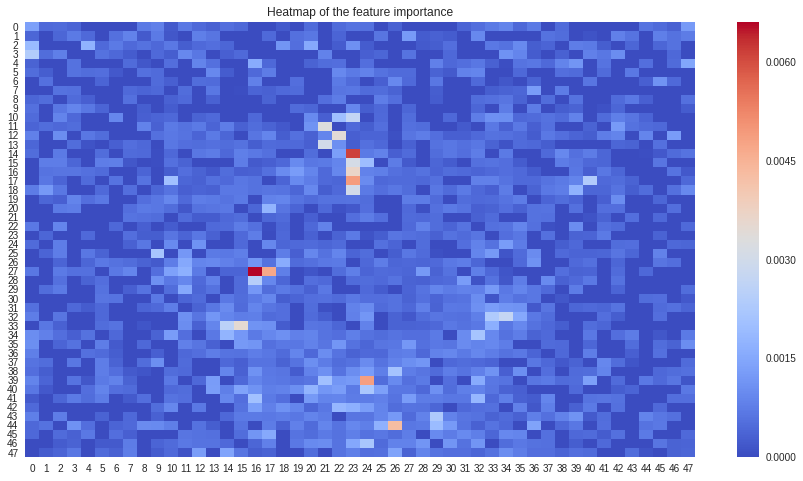

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(model.feature_importances_.reshape(48,48), cmap='coolwarm')
plt.title("Heatmap of the feature importance")
plt.show()

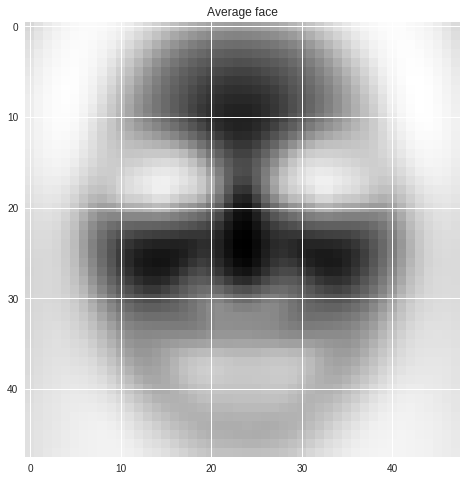

In [ ]:
plt.figure(figsize=(12,8))
plt.imshow(np.mean(X_train, axis=0).reshape(48,48))
plt.title("Average face")
plt.show()

In [ ]:
dic = { 0: "Angry",
       1: "Disgust",
       2:"Fear",
       3:"Happy",
       4:"Sad",
       5:"Surprise",
       6:"Neutral"}

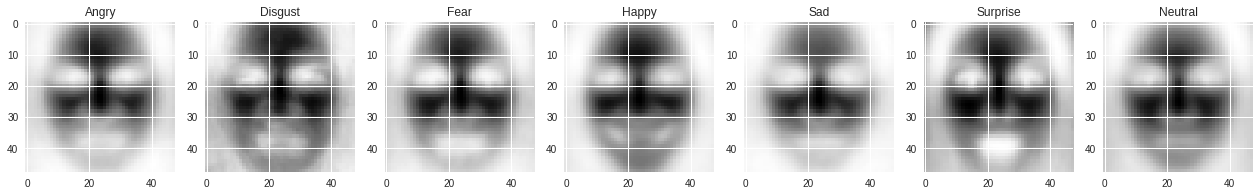

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(22, 8))

for i, ax in enumerate(axes):
    ax.imshow(np.mean(X_train[np.argmax(y_train, axis=1) == i], axis=0).reshape(48,48))
    ax.set_title(dic[i])

# IV. AutoEncoding for Data Visualization

### Build the AutoEncoder

In [ ]:
input_img = Input(shape=(shape_x, shape_y, 1))

# Ecoding
x = Conv2D(1, (5, 5), padding='same', activation='relu')(input_img)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)
x = Conv2D(1, (5, 5), padding='same', activation='relu')(x)
encoded = MaxPooling2D(pool_size=(2,2), padding='same')(x)


# Decoding
x = Conv2D(1,(5, 5), padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(1,(5, 5), padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1,(3, 3), padding='same', activation = 'linear')(x)

In [ ]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 48, 48, 1)         26        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 1)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 24, 24, 1)         26        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 1)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 12, 12, 1)         26        
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 24, 24, 1)         0         
__________

In [ ]:
epochs = 30
batch_size = 16

history = autoencoder.fit( X_train.reshape(-1, shape_x, shape_y, 1), X_train.reshape(-1, shape_x, shape_y, 1), batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 22967 samples, validate on 5742 samples
Epoch 1/30
22967/22967 [==============================] - 13s 550us/sample - loss: 0.0388 - val_loss: 0.0167
Epoch 2/30
22967/22967 [==============================] - 11s 493us/sample - loss: 0.0147 - val_loss: 0.0133
Epoch 3/30
22967/22967 [==============================] - 11s 493us/sample - loss: 0.0128 - val_loss: 0.0123
Epoch 4/30
22967/22967 [==============================] - 11s 495us/sample - loss: 0.0120 - val_loss: 0.0118
Epoch 5/30
22967/22967 [==============================] - 11s 491us/sample - loss: 0.0115 - val_loss: 0.0114
Epoch 6/30
22967/22967 [==============================] - 11s 498us/sample - loss: 0.0113 - val_loss: 0.0113
Epoch 7/30
22967/22967 [==============================] - 11s 490us/sample - loss: 0.0112 - val_loss: 0.0112
Epoch 8/30
22967/22967 [==============================] - 11s 487us/sample - loss: 0.0112 - val_loss: 0.0112
Epoch 9/30
22967/22967 [==============================] - 11s 483us/sample - lo

Text(0.5, 1.0, 'Loss Curves')

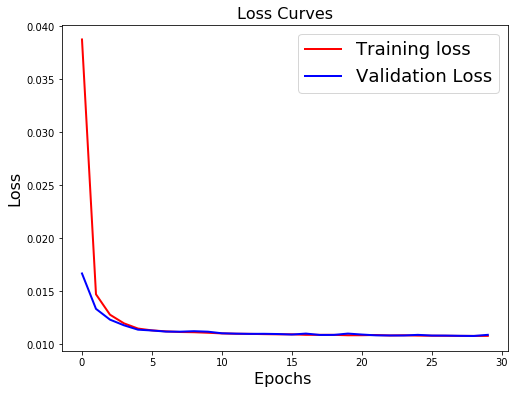

In [ ]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

### Visualize the encoded image

In [ ]:
encoder = Model(inputs = input_img, outputs = encoded)
encoded_imgs = encoder.predict(X_train.reshape(-1,shape_x, shape_y, 1))
decoded_imgs = autoencoder.predict(X_train.reshape(-1,shape_x, shape_y, 1))

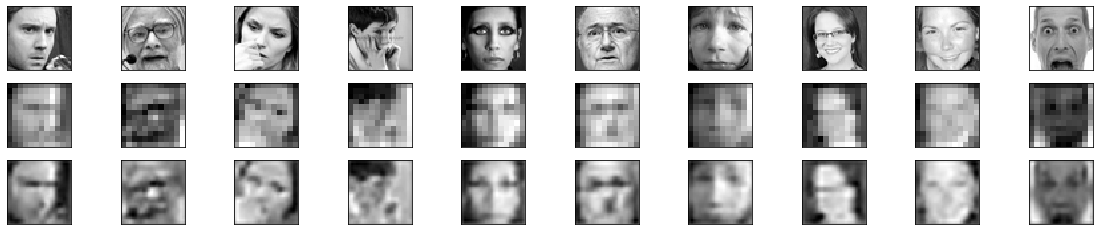

In [ ]:
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_train[i].reshape(shape_x, shape_y), cmap='gray')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Encoded images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(12,12), cmap='gray')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(shape_x, shape_y), cmap='gray')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Visualize the encoded images using T-SNE

In [ ]:
rndperm = np.random.permutation(np.reshape(encoded_imgs, (-1,12*12)).shape[0])

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(np.reshape(encoded_imgs, (-1,12*12))[rndperm[:n_sne]])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.043s...
[t-SNE] Computed neighbors for 7000 samples in 13.112s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 0.687499
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.592796
[t-SNE] KL divergence after 300 iterations: 2.939095


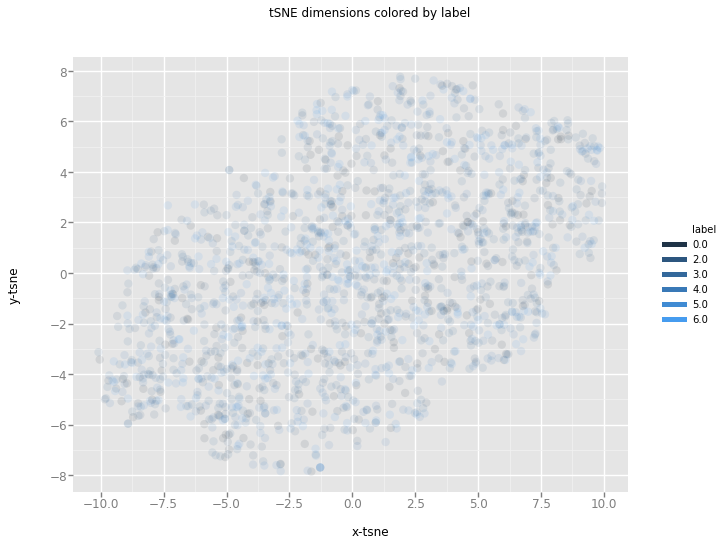

<ggplot: (-9223363279461800914)>

In [ ]:
df_tsne = pd.DataFrame(np.reshape(encoded_imgs, (-1,12*12))[rndperm[:n_sne],:])
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]
df_tsne['label'] = pd.DataFrame(y_train).idxmax(axis=1)[rndperm[:n_sne]]

chart = ggplot(df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + scale_color_brewer(type='diverging', palette=4) \
        + ggtitle("tSNE dimensions colored by label")
chart

# V. A simple model

### Build the model

In [ ]:
def createModel():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(7))
    model.add(Activation('softmax'))

    return model
model = createModel()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 24, 24, 128)       512       
__________

### Fit with a validation set

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 30

history_cnn_1 = model.fit(
    X_train, y_train,
    epochs = epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    class_weight=class_weight)

Train on 28709 samples, validate on 3589 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
28709/28709 [==============================] - 24s 836us/sample - loss: 1.9711 - acc: 0.2253 - val_loss: 2.0105 - val_acc: 0.0744
Epoch 2/30
28709/28709 [==============================] - 22s 767us/sample - loss: 1.6597 - acc: 0.3605 - val_loss: 1.9993 - val_acc: 0.1700
Epoch 3/30
28709/28709 [==============================] - 22s 766us/sample - loss: 1.4751 - acc: 0.4243 - val_loss: 1.4310 - val_acc: 0.4575
Epoch 4/30
28709/28709 [==============================] - 22s 767us/sample - loss: 1.3459 - acc: 0.4759 - val_loss: 1.4046 - val_acc: 0.4539
Epoch 5/30
28709/28709 [==============================] - 22s 766us/sample - loss: 1.2727 - acc: 0.5040 - val_loss: 1.3006 - val_acc: 0.5015
Epoch 6/30
  128/28709 [..............................] - ETA: 20s - loss: 0.9986 - acc: 0.5703

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Accuracy Curves')

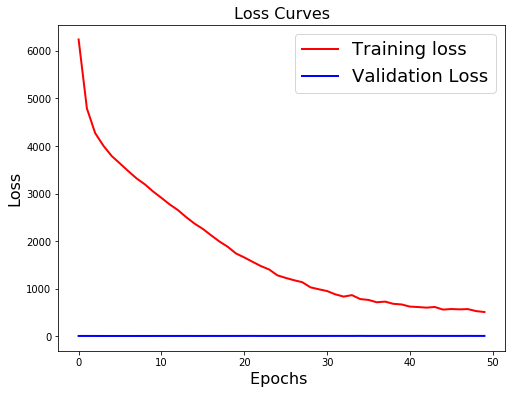

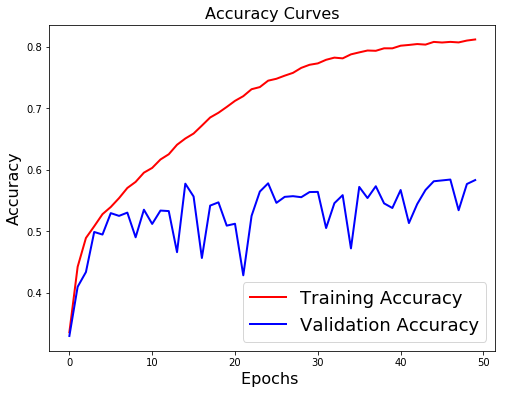

In [ ]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_cnn_1.history['loss'],'r',linewidth=2.0)
plt.plot(history_cnn_1.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_cnn_1.history['acc'],'r',linewidth=2.0)
plt.plot(history_cnn_1.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
model.save('drive/My Drive/FilRouge/cnn_1.h5')

### Fit on augmented images

In [ ]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

In [ ]:
#Creating 2nd model and training(fitting)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 50

# Fit the model on the batches generated by datagen.flow().
history_cnn_2 = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs,
    validation_data=(X_test, y_test),
    class_weight=class_weight)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
225/225 [==============================] - 30s 134ms/step - loss: 6920.9518 - acc: 0.2740 - val_loss: 2.2168 - val_acc: 0.3249
Epoch 2/50
225/225 [==============================] - 24s 109ms/step - loss: 5713.7485 - acc: 0.3563 - val_loss: 2.6106 - val_acc: 0.2875
Epoch 3/50
225/225 [==============================] - 24s 109ms/step - loss: 5076.1748 - acc: 0.4130 - val_loss: 2.0471 - val_acc: 0.4464
Epoch 4/50
225/225 [==============================] - 25s 109ms/step - loss: 4718.5790 - acc: 0.4469 - val_loss: 2.1747 - val_acc: 0.4592
Epoch 5/50
225/225 [==============================] - 24s 109ms/step - loss: 4485.0972 - acc: 0.4652 - val_loss: 2.1820 - val_acc: 0.4589
Epoch 6/50
225/225 [==============================] - 24s 108ms/step - loss: 4343.2076 - acc: 0.4792 - val_loss: 2.0668 - val_acc: 0.4921
Epoch 7/50
225/225 [==============================] - 24s 109ms/step - loss: 4234.6721 - acc: 0.4873 - val_loss: 2.0472 - va

Text(0.5, 1.0, 'Accuracy Curves')

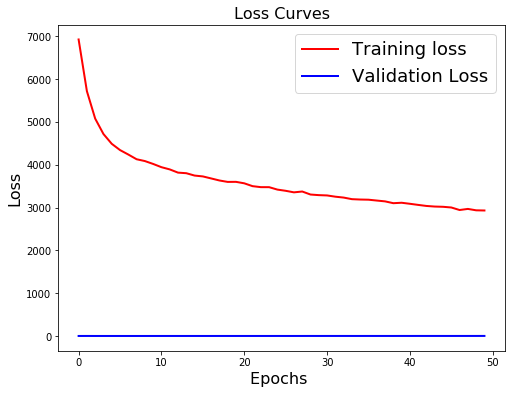

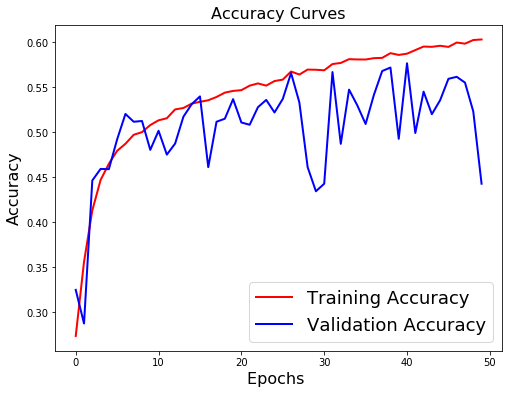

In [ ]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_cnn_2.history['loss'],'r',linewidth=2.0)
plt.plot(history_cnn_2.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_cnn_2.history['acc'],'r',linewidth=2.0)
plt.plot(history_cnn_2.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
model.save('drive/My Drive/FilRouge/cnn_2.h5')

# VI. XCeption

### Build the model

In [ ]:
def entry_flow(inputs) :

    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    previous_block_activation = x

    for size in [64, 128, 256] :

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding='same')(x)

        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)

        x = tensorflow.keras.layers.Add()([x, residual])
        previous_block_activation = x

    return x

In [ ]:
def middle_flow(x, num_blocks=8) :

    previous_block_activation = x

    for _ in range(num_blocks) :

        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = tensorflow.keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x

    return x

In [ ]:
def exit_flow(x) :

    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = tensorflow.keras.layers.Add()([x, residual])

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(7, activation='softmax', activity_regularizer=l2(0.001))(x)

    return x

In [ ]:
inputs = Input(shape=(shape_x, shape_y, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))
xception = Model(inputs, outputs)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
xception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 24, 24, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 24, 24, 32)   0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

### Fit on the train set

In [ ]:
batch_size = 32
epochs = 50

earlyStopping = EarlyStopping(monitor='val_acc', patience=10, verbose=0, mode='max')
mcp_save = ModelCheckpoint('drive/My Drive/FilRouge/xception_1.hdf5', save_best_only=True, monitor='val_acc', mode='max')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')

xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_xception_1 = xception.fit(
    X_train.reshape(-1,shape_x,shape_y,1), y_train,
    batch_size=batch_size,
    callbacks=[earlyStopping, mcp_save, reduce_lr_acc],
    epochs = epochs,
    validation_data = (X_test, y_test) ,
    class_weight = class_weight)

Train on 28709 samples, validate on 3589 samples
Epoch 1/50
28709/28709 [==============================] - 264s 9ms/sample - loss: 1.2253 - acc: 0.3810 - val_loss: 2.5365 - val_acc: 0.3823
Epoch 2/50
28709/28709 [==============================] - 89s 3ms/sample - loss: 1.0173 - acc: 0.4688 - val_loss: 2.6541 - val_acc: 0.3778
Epoch 3/50
28709/28709 [==============================] - 91s 3ms/sample - loss: 0.9204 - acc: 0.5058 - val_loss: 2.2777 - val_acc: 0.4035
Epoch 4/50
28709/28709 [==============================] - 91s 3ms/sample - loss: 0.8525 - acc: 0.5343 - val_loss: 2.6134 - val_acc: 0.4528
Epoch 5/50
28709/28709 [==============================] - 91s 3ms/sample - loss: 0.7926 - acc: 0.5525 - val_loss: 2.5041 - val_acc: 0.4812
Epoch 6/50
28709/28709 [==============================] - 91s 3ms/sample - loss: 0.7334 - acc: 0.5793 - val_loss: 2.2111 - val_acc: 0.4943
Epoch 7/50
28709/28709 [==============================] - 88s 3ms/sample - loss: 0.6748 - acc: 0.6021 - val_loss: 2.

Text(0.5, 1.0, 'Accuracy Curves')

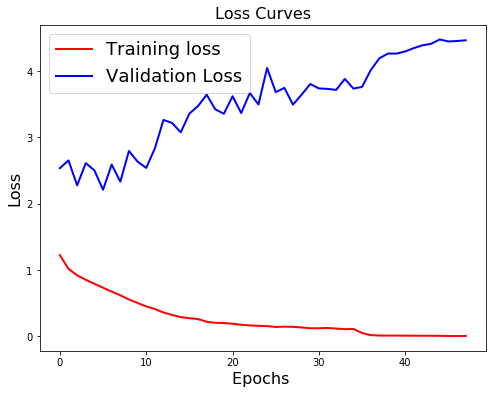

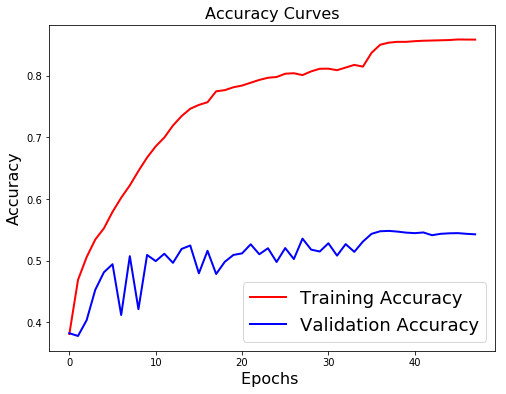

In [ ]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_xception_1.history['loss'],'r',linewidth=2.0)
plt.plot(history_xception_1.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_xception_1.history['acc'],'r',linewidth=2.0)
plt.plot(history_xception_1.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
xception.save('drive/My Drive/FilRouge/xception_1.h5')

### Fit on augmented images

In [ ]:
xception = Model(inputs, outputs)
xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
datagen = ImageDataGenerator(
        zoom_range=0.20,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.10,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.10,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

epochs = 35
batch_size = 128

In [ ]:
earlyStopping = EarlyStopping(monitor='val_acc', patience=10, verbose=0, mode='max')
mcp_save = ModelCheckpoint('drive/My Drive/FilRouge/xception_2.hdf5', save_best_only=True, monitor='val_acc', mode='max')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')

In [ ]:
history_xception_2 = xception.fit_generator(
    datagen.flow(X_train.reshape(-1, shape_x, shape_y, 1), y_train, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs,
    callbacks=[earlyStopping, mcp_save, reduce_lr_acc],
    class_weight = class_weight,
    validation_data=(X_test, y_test))

Epoch 1/35
225/225 [==============================] - 42s 186ms/step - loss: 0.7745 - acc: 0.6805 - val_loss: 1.0247 - val_acc: 0.6275
Epoch 2/35
225/225 [==============================] - 42s 186ms/step - loss: 0.7792 - acc: 0.6795 - val_loss: 1.0254 - val_acc: 0.6247
Epoch 3/35
225/225 [==============================] - 42s 188ms/step - loss: 0.7698 - acc: 0.6814 - val_loss: 1.0320 - val_acc: 0.6255
Epoch 4/35
225/225 [==============================] - 42s 185ms/step - loss: 0.7826 - acc: 0.6788 - val_loss: 1.0228 - val_acc: 0.6278
Epoch 5/35
225/225 [==============================] - 42s 186ms/step - loss: 0.7720 - acc: 0.6833 - val_loss: 1.0230 - val_acc: 0.6297
Epoch 6/35
225/225 [==============================] - 42s 187ms/step - loss: 0.7740 - acc: 0.6827 - val_loss: 1.0231 - val_acc: 0.6275
Epoch 7/35
225/225 [==============================] - 42s 186ms/step - loss: 0.7701 - acc: 0.6843 - val_loss: 1.0236 - val_acc: 0.6278
Epoch 8/35
225/225 [==============================] - 4

Text(0.5, 1.0, 'Accuracy Curves')

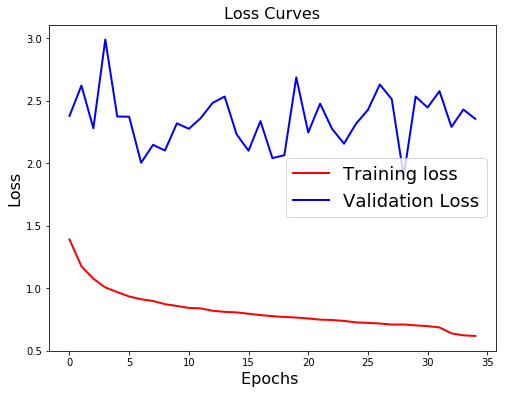

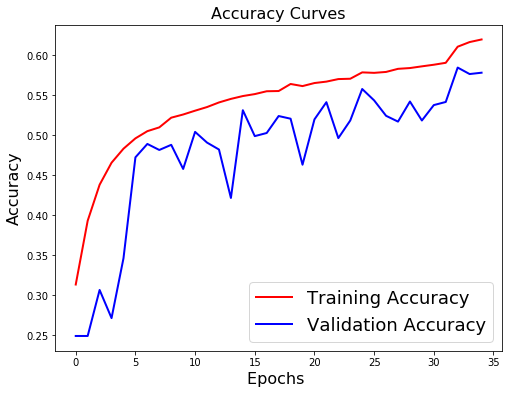

In [ ]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_xception_2.history['loss'],'r',linewidth=2.0)
plt.plot(history_xception_2.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_xception_2.history['acc'],'r',linewidth=2.0)
plt.plot(history_xception_2.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
xception.save('drive/My Drive/FilRouge/xception_2.h5')

### Prediction

In [ ]:
pred = model.predict(X_test.reshape(-1, shape_x, shape_y, 1))

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

In [ ]:
pred = enc.fit_transform(np.argmax(pred, axis=1))

(array([501.,   0.,   0.,  74.,   0.,   0., 370.,   0.,   0.,   0., 838.,
          0.,   0., 621.,   0.,   0., 479.,   0.,   0., 706.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6,
        3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ]),
 <a list of 20 Patch objects>)

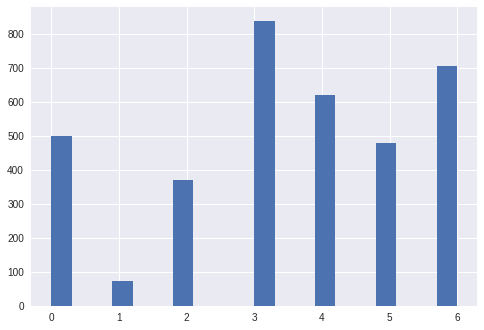

In [ ]:
plt.hist(np.argmax(pred, axis=1), bins=20)

In [ ]:
pred.shape

(3589, 7)

In [ ]:
accuracy_score(y_test, pred)

0.6316522708275285

# VII. VGG16

### Build the model

In [ ]:
img_input = Input(shape=(shape_x,shape_y,1))

# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)

# Classification block
x = Flatten(name='flatten')(x)
x = Dense(4096, name='fc6')(x)
x = Dense(7, name='fc11')(x)
x = Activation('softmax', name='fc11/softmax')(x)

model = Model(img_input, x, name='vggface_vgg16')

### Fit on the train set

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 30

earlyStopping = EarlyStopping(monitor='val_acc', patience=10, verbose=0, mode='max')
mcp_save = ModelCheckpoint('drive/My Drive/FilRouge/vgg16_1.hdf5', save_best_only=True, monitor='val_acc', mode='max')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')

history_vgg16_1 = model.fit(
    X_train, y_train,
    epochs = epochs,
    callbacks=[earlyStopping, mcp_save, reduce_lr_acc],
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    class_weight=class_weight)

Train on 28709 samples, validate on 3589 samples
Epoch 1/30
28709/28709 [==============================] - 86s 3ms/sample - loss: 9.4743 - acc: 0.2505 - val_loss: 12.0987 - val_acc: 0.2494
Epoch 2/30
28709/28709 [==============================] - 54s 2ms/sample - loss: 9.5371 - acc: 0.2513 - val_loss: 12.0987 - val_acc: 0.2494
Epoch 3/30
28709/28709 [==============================] - 54s 2ms/sample - loss: 9.5318 - acc: 0.2513 - val_loss: 12.0987 - val_acc: 0.2494
Epoch 4/30
27776/28709 [============================>.] - ETA: 1s - loss: 9.5286 - acc: 0.2516

KeyboardInterrupt: ignored

In [ ]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_vgg16_1.history['loss'],'r',linewidth=2.0)
plt.plot(history_vgg16_1.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_vgg16_1.history['acc'],'r',linewidth=2.0)
plt.plot(history_vgg16_1.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
model.save('drive/My Drive/FilRouge/vgg16_1.h5')

### Fit on augmented images

In [ ]:
datagen = ImageDataGenerator(
        zoom_range=0.20,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.10,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.10,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 50

# Fit the model on the batches generated by datagen.flow().
history_vgg16_2 = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs,
    validation_data=(X_test, y_test), class_weight=class_weight)

In [ ]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_vgg16_2.history['loss'],'r',linewidth=2.0)
plt.plot(history_vgg16_2.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_vgg16_2.history['acc'],'r',linewidth=2.0)
plt.plot(history_vgg16_2.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
model.save('drive/My Drive/FilRouge/vgg16_2.h5')

# VIII. VGG19

### Build the model

In [ ]:
inputs = Input(shape=(shape_x, shape_y, 1))

# Block 1
x = layers.Conv2D(64, (3, 3),activation='relu',padding='same',name='block1_conv1')(inputs)
x = layers.Conv2D(64, (3, 3),activation='relu',padding='same',name='block1_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = layers.Conv2D(128, (3, 3),activation='relu',padding='same',name='block2_conv1')(x)
x = layers.Conv2D(128, (3, 3),activation='relu',padding='same',name='block2_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = layers.Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv1')(x)
x = layers.Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv2')(x)
x = layers.Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv3')(x)
x = layers.Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv4')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv1')(x)
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv2')(x)
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv3')(x)
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv4')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv1')(x)
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv2')(x)
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv3')(x)
x = layers.Conv2D(512, (3, 3),activation='relu',padding='same',name='block5_conv4')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

x = layers.Flatten(name='flatten')(x)
x = layers.Dense(4096, activation='relu', name='fc1')(x)
x = layers.Dense(4096, activation='relu', name='fc2')(x)
x = layers.Dense(7, activation='softmax', name='predictions')(x)

model = models.Model(inputs, x, name='vgg19')

### Fit on the train set

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 30

earlyStopping = EarlyStopping(monitor='val_acc', patience=10, verbose=0, mode='max')
mcp_save = ModelCheckpoint('drive/My Drive/FilRouge/vgg19_1.hdf5', save_best_only=True, monitor='val_acc', mode='max')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')

history_vgg19_1 = model.fit(
    X_train, y_train,
    epochs = epochs,
    callbacks=[earlyStopping, mcp_save, reduce_lr_acc],
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    class_weight=class_weight)

Train on 28709 samples, validate on 3589 samples
Epoch 1/30
28709/28709 [==============================] - 107s 4ms/sample - loss: 9.4723 - acc: 0.2513 - val_loss: 12.0987 - val_acc: 0.2494
Epoch 2/30
28709/28709 [==============================] - 70s 2ms/sample - loss: 9.5336 - acc: 0.2513 - val_loss: 12.0987 - val_acc: 0.2494
Epoch 3/30
28709/28709 [==============================] - 70s 2ms/sample - loss: 9.5333 - acc: 0.2513 - val_loss: 12.0987 - val_acc: 0.2494
Epoch 4/30
28709/28709 [==============================] - 70s 2ms/sample - loss: 9.5345 - acc: 0.2513 - val_loss: 12.0987 - val_acc: 0.2494
Epoch 5/30
 9856/28709 [=========>....................] - ETA: 44s - loss: 9.4805 - acc: 0.2525

KeyboardInterrupt: ignored

In [ ]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_vgg19_1.history['loss'],'r',linewidth=2.0)
plt.plot(history_vgg19_1.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_vgg19_1.history['acc'],'r',linewidth=2.0)
plt.plot(history_vgg19_1.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
model.save('drive/My Drive/FilRouge/vgg19_1.h5')

### Fit on augmented images

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 50

# Fit the model on the batches generated by datagen.flow().
history_vgg19_2 = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs,
    validation_data=(X_test, y_test),
    class_weight=class_weight)

In [ ]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_vgg19_2.history['loss'],'r',linewidth=2.0)
plt.plot(history_vgg19_2.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_vgg19_2.history['acc'],'r',linewidth=2.0)
plt.plot(history_vgg19_2.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
model.save('drive/My Drive/FilRouge/vgg19_2.h5')

# IX. DenseNet

### Build the model

In [ ]:
input_image = Input(shape=(shape_x, shape_y, 1))
x = BatchNormalization()(input_image)

base_model = densenet.DenseNet121(input_shape=(shape_x, shape_y, 1),classes = 7,weights=None,include_top=False,pooling='avg')

x = base_model(x)
x = Flatten()(x)
x = Dense(7, activation='softmax', name='fc2')(x)

### Fit on the train set

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 30

earlyStopping = EarlyStopping(monitor='val_acc', patience=10, verbose=0, mode='max')
mcp_save = ModelCheckpoint('drive/My Drive/FilRouge/dense_1.hdf5', save_best_only=True, monitor='val_acc', mode='max')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')

history_densenet_1 = model.fit(
    X_train, y_train,
    epochs = epochs,
    #callbacks=[earlyStopping, mcp_save, reduce_lr_acc],
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    class_weight=class_weight)

Train on 28709 samples, validate on 3589 samples
Epoch 1/30
28709/28709 [==============================] - 74s 3ms/sample - loss: 9.5410 - acc: 0.2513 - val_loss: 12.0987 - val_acc: 0.2494
Epoch 2/30
 5888/28709 [=====>........................] - ETA: 53s - loss: 9.4136 - acc: 0.2561

KeyboardInterrupt: ignored

In [ ]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_densenet_1.history['loss'],'r',linewidth=2.0)
plt.plot(history_densenet_1.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_densenet_1.history['acc'],'r',linewidth=2.0)
plt.plot(history_densenet_1.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
model.save('drive/My Drive/FilRouge/densenet_1.h5')

### Fit on augmented images

In [ ]:
datagen = ImageDataGenerator(
        zoom_range=0.20,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.10,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.10,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 50

# Fit the model on the batches generated by datagen.flow().
history_densenet_2 = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs,
    validation_data=(X_test, y_test),
    class_weight=class_weight)

# X. Activation Maps

We will build a simple model whose only role will be to show the activation maps of our CNN.

In [ ]:
from keras.models import load_model
model = load_model('drive/My Drive/FilRouge/final_xception.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
from keras import backend as K
from keras import applications
from keras import models
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import optimizers
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Input, Dropout, Flatten, Dense, GlobalAveragePooling2D, Activation, Conv2D, MaxPooling2D, LeakyReLU, AveragePooling2D

In [ ]:
input_shape = (48, 48, 1)
Xp_in = Input(shape = input_shape, name='Input')
Xp = Conv2D(16, kernel_size=(3, 3), activation='relu',
                 input_shape=input_shape)(Xp_in)
Xp = MaxPooling2D(pool_size=(2, 2))(Xp)
Xp = Conv2D(64, kernel_size=(3, 3), activation='relu')(Xp)
Xp = MaxPooling2D(pool_size=(2, 2))(Xp)
Xp = Conv2D(128, kernel_size=(3, 3), activation='relu')(Xp)
Xp = MaxPooling2D(pool_size=(2, 2))(Xp)
Xp = Flatten()(Xp)
Xp = Dense(512, activation='relu')(Xp)
Xp = Dropout(0.3)(Xp)
Xp = Dense(512, activation='relu')(Xp)
Xp = Dropout(0.3)(Xp)
Xp_out = Dense(7, activation='sigmoid')(Xp)

prediction_model = Model(inputs=Xp_in, outputs=Xp_out)

prediction_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 16)        160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 64)        9280      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 128)         0         
__________

In [ ]:
prediction_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 25

history_cnn_1 = prediction_model.fit(
    X_train, y_train,
    epochs = epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    class_weight=class_weight)

Train on 28709 samples, validate on 3589 samples
Epoch 1/25
28709/28709 [==============================] - 8s 288us/step - loss: 4.7405e-04 - acc: 0.1047 - val_loss: 1.9246 - val_acc: 0.2123
Epoch 2/25
28709/28709 [==============================] - 5s 166us/step - loss: 4.5787e-04 - acc: 0.2118 - val_loss: 1.8705 - val_acc: 0.2003
Epoch 3/25
28709/28709 [==============================] - 5s 166us/step - loss: 4.2316e-04 - acc: 0.3119 - val_loss: 1.7057 - val_acc: 0.3332
Epoch 4/25
28709/28709 [==============================] - 5s 166us/step - loss: 3.8323e-04 - acc: 0.3886 - val_loss: 1.6807 - val_acc: 0.3614
Epoch 5/25
28709/28709 [==============================] - 5s 166us/step - loss: 3.5203e-04 - acc: 0.4344 - val_loss: 1.4482 - val_acc: 0.4394
Epoch 6/25
28709/28709 [==============================] - 5s 167us/step - loss: 3.2483e-04 - acc: 0.4703 - val_loss: 1.3690 - val_acc: 0.4831
Epoch 7/25
28709/28709 [==============================] - 5s 167us/step - loss: 3.0560e-04 - acc: 0

In [ ]:
# Let's look at the output from the last convolution layer named 'conv2d_3'
penultimate_layer = utils.find_layer_idx(prediction_model, 'conv2d_9')
layer_idx = utils.find_layer_idx(prediction_model, 'conv2d_9')

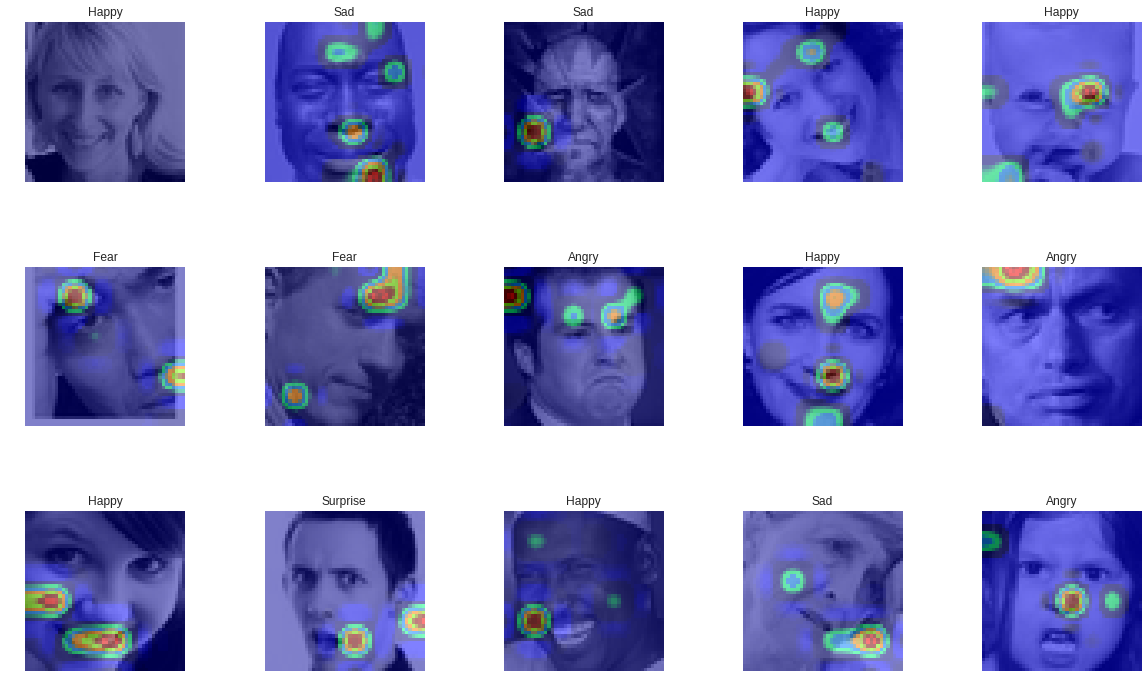

In [ ]:
import matplotlib.cm as cm
import random as rnd

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12), squeeze = False)
fig.subplots_adjust(hspace = 0.5,wspace = 0.5)
rnd.seed(10)

for row in axes:
  for ax in row:
      i = rnd.randint(0, X_train.shape[0])
      img = X_train.reshape(X_train.shape[0], 48, 48,1)[i]
      grads = visualize_cam(prediction_model, layer_idx=layer_idx, filter_indices=20,
                            seed_input=img, penultimate_layer_idx=penultimate_layer,
                            backprop_modifier=None)

      jet_heatmap = np.uint8((cm.jet(grads))[..., 0] * 255).reshape(shape_x,shape_x, 3)
      #jet_heatmap = np.dot(jet_heatmap , [0.299 , 0.587, 0.114]).reshape(shape_x, shape_y)
      img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
      ax.imshow(img)
      ax.imshow(jet_heatmap, alpha=0.5)
      ax.set_title(dic[np.argmax(y_train[i])])
      ax.axis('off')

# X. Models summary

In [ ]:
# Loss Curves
plt.figure(figsize=[15,9])

# CNN-1
plt.plot(history_cnn_1.history['loss'],'r',linewidth=2.0, label="CNN")
plt.plot(history_cnn_1.history['val_loss'],'b',linewidth=2.0, label="CNN Val")

# CNN-1
plt.plot(history_cnn_2.history['loss'],'r',linewidth=2.0, label="CNN-Aug")
plt.plot(history_cnn_2.history['val_loss'],'b',linewidth=2.0, label="CNN-Aug Val")

# XCeption-1
plt.plot(history_xception_1.history['loss'],'r',linewidth=2.0, label="XCeption")
plt.plot(history_xception_1.history['val_loss'],'b',linewidth=2.0, label="XCeption Val")

# XCeption-2
plt.plot(history_xception_2.history['loss'],'r',linewidth=2.0, label="XCeption-Aug")
plt.plot(history_xception_2.history['val_loss'],'b',linewidth=2.0, label="XCeption-Aug Val")

# VGG16-1
plt.plot(history_vgg16_1.history['loss'],'r',linewidth=2.0, label="VGG16")
plt.plot(history_vgg16_1.history['val_loss'],'b',linewidth=2.0, label="VGG16 Val")

# VGG16-2
plt.plot(history_vgg16_2.history['loss'],'r',linewidth=2.0, label="VGG16-Aug")
plt.plot(history_vgg16_2.history['val_loss'],'b',linewidth=2.0, label="VGG16-Aug Val")

# VGG19-1
plt.plot(history_vgg19_1.history['loss'],'r',linewidth=2.0, label="VGG19")
plt.plot(history_vgg19_1.history['val_loss'],'b',linewidth=2.0, label="VGG19 Val")

# VGG19-2
plt.plot(history_vgg19_2.history['loss'],'r',linewidth=2.0, label="VGG19-Aug")
plt.plot(history_vgg19_2.history['val_loss'],'b',linewidth=2.0, label="VGG19-Aug Val")

# DenseNet-1
plt.plot(history_densenet_1.history['loss'],'r',linewidth=2.0, label="DenseNet")
plt.plot(history_densenet_1.history['val_loss'],'b',linewidth=2.0, label="DenseNet Val")

# DenseNet-2
plt.plot(history_densenet_2.history['loss'],'r',linewidth=2.0, label="DenseNet-Aug")
plt.plot(history_densenet_2.history['val_loss'],'b',linewidth=2.0, label="DenseNet-Aug Val")

plt.legend()

plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)

plt.title('Loss Curves',fontsize=16)
plt.show()

In [ ]:
# Loss Curves
plt.figure(figsize=[15,9])

# CNN-1
plt.plot(history_cnn_1.history['acc'],'r',linewidth=2.0, label="CNN")
plt.plot(history_cnn_1.history['val_acc'],'b',linewidth=2.0, label="CNN Val")

# CNN-1
plt.plot(history_cnn_2.history['acc'],'r',linewidth=2.0, label="CNN-Aug")
plt.plot(history_cnn_2.history['val_acc'],'b',linewidth=2.0, label="CNN-Aug Val")

# XCeption-1
plt.plot(history_xception_1.history['acc'],'r',linewidth=2.0, label="XCeption")
plt.plot(history_xception_1.history['val_acc'],'b',linewidth=2.0, label="XCeption Val")

# XCeption-2
plt.plot(history_xception_2.history['acc'],'r',linewidth=2.0, label="XCeption-Aug")
plt.plot(history_xception_2.history['val_acc'],'b',linewidth=2.0, label="XCeption-Aug Val")

# VGG16-1
plt.plot(history_vgg16_1.history['acc'],'r',linewidth=2.0, label="VGG16")
plt.plot(history_vgg16_1.history['val_acc'],'b',linewidth=2.0, label="VGG16 Val")

# VGG16-2
plt.plot(history_vgg16_2.history['acc'],'r',linewidth=2.0, label="VGG16-Aug")
plt.plot(history_vgg16_2.history['val_acc'],'b',linewidth=2.0, label="VGG16-Aug Val")

# VGG19-1
plt.plot(history_vgg19_1.history['acc'],'r',linewidth=2.0, label="VGG19")
plt.plot(history_vgg19_1.history['val_acc'],'b',linewidth=2.0, label="VGG19 Val")

# VGG19-2
plt.plot(history_vgg19_2.history['acc'],'r',linewidth=2.0, label="VGG19-Aug")
plt.plot(history_vgg19_2.history['val_acc'],'b',linewidth=2.0, label="VGG19-Aug Val")

# DenseNet-1
plt.plot(history_densenet_1.history['acc'],'r',linewidth=2.0, label="DenseNet")
plt.plot(history_densenet_1.history['val_acc'],'b',linewidth=2.0, label="DenseNet Val")

# DenseNet-2
plt.plot(history_densenet_2.history['acc'],'r',linewidth=2.0, label="DenseNet-Aug")
plt.plot(history_densenet_2.history['val_acc'],'b',linewidth=2.0, label="DenseNet-Aug Val")

plt.legend()

plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)

plt.title('Accuracy Curves',fontsize=16)
plt.show()

# X. Model Stacking

# XI. Sources
- Visualization : https://github.com/JostineHo/mememoji/blob/master/data_visualization.ipynb
- State of the art Architecture : https://github.com/amineHorseman/facial-expression-recognition-using-cnn
- Eyes Tracking : https://www.pyimagesearch.com/2017/04/24/eye-blink-detection-opencv-python-dlib/
- Face Alignment : https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/
- C.Pramerdorfer,  and  M.Kampel.Facial  Expression  Recognition  using  Con-volutional  Neural  Networks:  State  of  the  Art.  Computer  Vision  Lab,  TU  Wien. https://arxiv.org/pdf/1612.02903.pdf
- A Brief Review of Facial Emotion Recognition Based
on Visual Information : https://www.mdpi.com/1424-8220/18/2/401/pdf
- Going deeper in facial expression recognition using deep neural networks : https://ieeexplore.ieee.org/document/7477450